In [1]:
# Khai báo thư viện
# Khai báo hàm

import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
# from sklearn import metrics
import pandas as pd
import math

# Cấu hình trả về kết quả sau mỗi ô code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
# from scipy import signal

feature_names = ['mean_x', 'mean_y', 'mean_z',
                 'mean_x2', 'mean_y2', 'mean_z2',
                 'rms_x', 'rms_y', 'rms_z',
                 'rms_x2', 'rms_y2', 'rms_z2',
                 'std_x', 'std_y', 'std_z',
                 'std_x2', 'std_y2', 'std_z2',
                'med_x', 'med_y', 'med_z',
                'med_x2', 'med_y2', 'med_z2']

target_names = ['Feeding', 'Lying', 'Standing', 'Normal Walking']

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    Trả về 1 ma trận xoay theo chiều ngược kim đồng hồ quanh trục được xác định với vecto axis
    và 1 góc quay theta radian.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
    
    
def featuresFromBuffer(at, fs):
    feat = np.zeros(24) # 30 o day la size of features
    x = np.array(at.iloc[:,0], dtype=np.float64)   # x acceleration component (leg) thành phần gia tốc ở chân
    y = np.array(at.iloc[:,1], dtype=np.float64)   # y
    z = np.array(at.iloc[:,2], dtype=np.float64)   # z
    x2 = np.array(at.iloc[:,3], dtype=np.float64)   # x2 acceleration component (collar) thành phần gia tốc ở cổ
    y2 = np.array(at.iloc[:,4], dtype=np.float64)   # y2
    z2 = np.array(at.iloc[:,5], dtype=np.float64)   # z2
    # t2 = np.array(at.iloc[:,3]**2 + at.iloc[:,4]**2 + at.iloc[:,5]**2, dtype=np.float64)
    # k2 = np.array(at.iloc[:,0]**2 + at.iloc[:,1]**2 + at.iloc[:,2]**2, dtype=np.float64)
    
    # Average value in signal buffer for all three acceleration components (1 each)    
    # Giá trị trung bình 
    means = [np.mean(i) for i in [x, y, z]]
    #means = [np.mean(np.sqrt(i)) for i in [k2]]
    #means = [np.mean(np.sqrt(i)) for i in [k3]]
    feat[0:3] = means

    means2 = [np.mean(i) for i in [x2, y2, z2]]
    #means2 = [np.mean(np.sqrt(i)) for i in [t2]]
    #means2 = [np.mean(np.sqrt(i)) for i in [t3]]
    feat[3:6] = means2
    
    #print(t2 , '1')
    
    # RMS value in signal buffer for all three acceleration components (1 each)
    # Giá trị hiệu dụng (Root mean square)
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    #rms = [np.sqrt(np.mean(np.sqrt(i))) for i in [k2]]
    #rms = [np.sqrt(np.mean(np.sqrt(i))) for i in [k3]]
    feat[6:9] = rms
    
    rms2 = [np.sqrt(np.mean(i**2)) for i in [x2, y2, z2]]
    #rms2 = [np.sqrt(np.mean(np.sqrt(i))) for i in [t2]]
    #rms2 = [np.sqrt(np.mean(np.sqrt(i))) for i in [t3]]
    feat[9:12] = rms2
    
    # Standard deviation
    # Độ lệch chuẩn 
    std = [np.std(i) for i in [x, y, z]]
    #std = [np.std(np.sqrt(i)) for i in [k2]]
    #std = [np.std(np.sqrt(i)) for i in [k3]]
    
    feat[12:15] = std
    std2 = [np.std(i) for i in [x2, y2, z2]]
    #std2 = [np.std(np.sqrt(i)) for i in [t2]]
    #std2 = [np.std(np.sqrt(i)) for i in [t3]]
    feat[15:18] = std2 

    # Variance
    # Phương sai 
    #var = [np.var(i) for i in [x, y, z]]
    #feat[9:12] = var
    
    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[18:21] = med
    med2 = [np.median(i) for i in [x2, y2, z2]]
    feat[21:24] = med2
    
    # Range
    # Dải giá trị
    # Range1 = [ np.amin(i) for i in [x, y, z]]    
    # feat[18:21] = Range1
    # Range2 = [ np.amax(i) for i in [x, y, z]]    
    # feat[21:24] = Range2
    # Range12 = [ np.amin(i) for i in [x2, y2, z2]]    
    # feat[24:27] = Range12
    # Range22 = [ np.amax(i) for i in [x2, y2, z2]]    
    # feat[27:30] = Range22
    
    # win_size = 3
    
    # Vecto tổng hợp gia tốc chuyển động toàn thân
    # np.float --> float
    # VeDBA = np.array(np.sqrt(abs(x[0] - (x[0]+x[1]+x[2])/win_size)**2 +
    #                          abs(y[0] - (y[0]+y[1]+y[2])/win_size)**2 + 
    #                          abs(z[0] - (z[0]+z[1]+z[2])/win_size)**2), dtype=float)
    # VeDBA2 = np.array(np.sqrt(abs(x2[0] - (x2[0]+x2[1]+x2[2])/win_size)**2 + 
    #                           abs(y2[0] - (y2[0]+y2[1]+y2[2])/win_size)**2 + 
    #                           abs(z2[0] - (z2[0]+z2[1]+z2[2])/win_size)**2), dtype=float)
    
    # # Gia tốc tĩnh, được chuẩn hóa theo g
    # SCAYz = np.array((z[0]+z[1]+z[2])/win_size, dtype=float)
    # SCAYz2 = np.array((z2[0]+z2[1]+z2[2])/win_size, dtype=float)
    # SCAYx = np.array((x[0]+x[1]+x[2])/win_size, dtype=float)
    # SCAYx2 = np.array((x2[0]+x2[1]+x2[2])/win_size, dtype=float)
    # SCAYy = np.array((y[0]+y[1]+y[2])/win_size, dtype=float)
    # SCAYy2 = np.array((y2[0]+y2[1]+y2[2])/win_size, dtype=float)
    
    # Average value in signal buffer for all three acceleration components (1 each)    
    #means = [np.mean(i) for i in [x, y, z]]
    #feat[0:3] = means
    #means2 = [np.mean(i) for i in [x2, y2, z2]]
    #feat[3:6] = means2
    #_ODBAs = [np.mean(i) for i in [ODBA]]
    #feat[0:3] = _ODBAs
    #_ODBAs2 = [np.mean(i) for i in [ODBA2]]
    #feat[3:6] = _ODBAs2

    # _VeDBAs = [np.std(i) for i in [VeDBA]]
    # feat[0:3] = _VeDBAs
    # _VeDBAs2 = [np.std(i) for i in [VeDBA2]]
    # feat[3:6] = _VeDBAs2

    # _SCAYy = [np.mean(i) for i in [SCAYy]]
    # feat[6:9] = _SCAYy
    # _SCAYy2 = [np.mean(i) for i in [SCAYy2]]
    # feat[9:12] = _SCAYy2
    # _SCAYx = [np.mean(i) for i in [SCAYx]]
    # feat[12:15] = _SCAYx
    # _SCAYx2 = [np.mean(i) for i in [SCAYx2]]
    # feat[15:18] = _SCAYx2
    # _SCAYz = [np.mean(i) for i in [SCAYz]]
    # feat[18:21] = _SCAYz
    # _SCAYz2 = [np.mean(i) for i in [SCAYz2]]
    # feat[21:24] = _SCAYz2
        
        
    return feat
    

In [2]:
# Import data

df = pd.read_excel('3CowData_2sensor.xlsx')


In [3]:
Feeding = df[['Feeding', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']]
Feeding = Feeding.dropna()
Feeding.index = pd.RangeIndex(len(Feeding.index))
Feeding = Feeding.drop(0)

# x = np.array(Feeding.iloc[:,0], dtype=np.float64)   # x acceleration component (leg) thành phần gia tốc ở chân
# y = np.array(Feeding.iloc[:,1], dtype=np.float64)   # y
# z = np.array(Feeding.iloc[:,2], dtype=np.float64)   # z

# means = [np.mean(i) for i in [x, y, z]]
# print(means)

# Mục mới

In [4]:
# Prepare data
# Load dữ liệu từ file excel lên

Feeding = df[['Feeding', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']]
Feeding = Feeding.dropna()
Feeding.index = pd.RangeIndex(len(Feeding.index))
Feeding = Feeding.drop(0)

axis = [1, 0, 0]
#lech 10 do
#theta = 0.174 

#lech 30 do
theta = 0.523

#lech 45 do
#theta = 0.785

for num in range(1, len(Feeding['Unnamed: 3'])%1):
  fed = np.dot(rotation_matrix(axis, theta), [Feeding['Unnamed: 3'][num], Feeding['Unnamed: 4'][num], Feeding['Unnamed: 5'][num]])
  Feeding['Unnamed: 3'][num] = fed[0]
  Feeding['Unnamed: 4'][num] = fed[1]
  Feeding['Unnamed: 5'][num] = fed[2]


Lying = df[['Lying', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']]
Lying = Lying.dropna()
Lying.index = pd.RangeIndex(len(Lying.index))
Lying = Lying.drop(0)
for num in range(1, len(Lying['Unnamed: 9'])%1):
  fed = np.dot(rotation_matrix(axis, theta), [Lying['Unnamed: 9'][num], Lying['Unnamed: 10'][num], Lying['Unnamed: 11'][num]])
  Lying['Unnamed: 9'][num] = fed[0]
  Lying['Unnamed: 10'][num] = fed[1]
  Lying['Unnamed: 11'][num] = fed[2]

Standing = df[['Standing', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17']]
Standing = Standing.dropna()
Standing.index = pd.RangeIndex(len(Standing.index))
Standing = Standing.drop(0)
for num in range(1, len(Standing['Unnamed: 15'])%1):
  fed = np.dot(rotation_matrix(axis, theta), [Standing['Unnamed: 15'][num], Standing['Unnamed: 16'][num], Standing['Unnamed: 17'][num]])
  Standing['Unnamed: 15'][num] = fed[0]
  Standing['Unnamed: 16'][num] = fed[1]
  Standing['Unnamed: 17'][num] = fed[2]

Normal_walking = df[['Normal walking', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23']]
Normal_walking = Normal_walking.dropna()
Normal_walking.index = pd.RangeIndex(len(Normal_walking.index))
Normal_walking = Normal_walking.drop(0)
for num in range(1, len(Normal_walking['Unnamed: 21'])%1):
  fed = np.dot(rotation_matrix(axis, theta), [Normal_walking['Unnamed: 21'][num], Normal_walking['Unnamed: 22'][num], Normal_walking['Unnamed: 23'][num]])
  Normal_walking['Unnamed: 21'][num] = fed[0]
  Normal_walking['Unnamed: 22'][num] = fed[1]
  Normal_walking['Unnamed: 23'][num] = fed[2]

In [5]:
# thuc hien windowing du lieu
# chia moi khoi du lieu 16s

window_size = 16
stride = 6

# window_size = 15
# stride = 3
train_ratio = 0.6

X_feeding_train = [Feeding[i:i+window_size] for i in range(0, int(len(Feeding)*train_ratio), stride) if i+window_size<=int(len(Feeding))]
X_feeding_test = [Feeding[i:i+window_size] for i in range(int(len(Feeding)*train_ratio), len(Feeding), stride) if i+window_size<=len(Feeding)]

X_lying_train = [Lying[i:i+window_size] for i in range(0, int(len(Lying)*train_ratio), stride) if i+window_size<=int(len(Lying))]
X_lying_test = [Lying[i:i+window_size] for i in range(int(len(Lying)*train_ratio), len(Lying), stride) if i+window_size<=len(Lying)]

X_standing_train = [Standing[i:i+window_size] for i in range(0, int(len(Standing)*train_ratio), stride) if i+window_size<=int(len(Standing))]
X_standing_test = [Standing[i:i+window_size] for i in range(int(len(Standing)*train_ratio), len(Standing), stride) if i+window_size<=len(Standing)]

X_normalw_train = [Normal_walking[i:i+window_size] for i in range(0, int(len(Normal_walking)*train_ratio), stride) if i+window_size<=int(len(Normal_walking))]
X_normalw_test = [Normal_walking[i:i+window_size] for i in range(int(len(Normal_walking)*train_ratio), len(Normal_walking), stride) if i+window_size<=len(Normal_walking)]

print('X_feeding_train: ', len(X_feeding_train))
print('X_feeding_test: ', len(X_feeding_test))

print('X_lying_train: ', len(X_lying_train))
print('X_lying_test: ', len(X_lying_test))

print('X_standing_train: ', len(X_standing_train))
print('X_standing_test: ', len(X_standing_test))

print('X_normalw_train: ', len(X_normalw_train))
print('X_normalw_test: ', len(X_normalw_test))

print('Total: \n')
print('Train: ', len(X_feeding_train)+len(X_lying_train)+len(X_standing_train)+
     len(X_normalw_train))
print('Test: ', len(X_feeding_test)+len(X_lying_test)+len(X_standing_test)+
     len(X_normalw_test))

X_feeding_train:  338
X_feeding_test:  223
X_lying_train:  321
X_lying_test:  212
X_standing_train:  895
X_standing_test:  594
X_normalw_train:  241
X_normalw_test:  158
Total: 

Train:  1795
Test:  1187


In [6]:
#Catch 'em all

my_train_data = []
my_train_lable = []

my_test_data = []
my_test_lable = []

for acts in X_feeding_train:
    my_train_data.append(acts)
    my_train_lable.append(0)

for acts in X_lying_train:
    my_train_data.append(acts)
    my_train_lable.append(1)
    
for acts in X_standing_train:
    my_train_data.append(acts)
    my_train_lable.append(2)  

for acts in X_normalw_train:
    my_train_data.append(acts)
    my_train_lable.append(3)

    
print('my-train-data\'s length: ', len(my_train_data) )
print('my-train-lable\'s length: ', len(my_train_lable) )

#Catch 'em all

for acts in X_feeding_test:
    my_test_data.append(acts)
    my_test_lable.append(0)

for acts in X_lying_test:
    my_test_data.append(acts)
    my_test_lable.append(1)
    
for acts in X_standing_test:
    my_test_data.append(acts)
    my_test_lable.append(2)

for acts in X_normalw_test:
    my_test_data.append(acts)
    my_test_lable.append(3)
    
print('my-test-data\'s length: ', len(my_test_data) )
print('my-test-lable\'s length: ', len(my_test_lable) )

my-train-data's length:  1795
my-train-lable's length:  1795
my-test-data's length:  1187
my-test-lable's length:  1187


In [7]:
train_features = []
test_features = []
for action in my_train_data:
    feat = featuresFromBuffer(action, 1)
    train_features.append(feat)
for action in my_test_data:
    feat = featuresFromBuffer(action, 1)
    test_features.append(feat)
    
len(train_features)
len(test_features)


1795

1187

In [8]:
# beginning of classification:

print("Decision Tree stuffs:")
from sklearn.tree import DecisionTreeClassifier

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, my_train_lable)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'
     .format(clf2.score(train_features, my_train_lable)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
     .format(clf2.score(test_features, my_test_lable)))



print("\n\nDecision Tree DTBD stuffs:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.5, max_depth=3, n_estimators=100).fit(train_features, my_train_lable)

print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, my_train_lable)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, my_test_lable)))


print("\n\nSVM stuffs:")
this_C = 100
clf = SVC(C=this_C).fit(train_features, my_train_lable)
print("Accuracy on training set: {:.2f}".format(clf.score(train_features, my_train_lable)))
print("Accuracy on test set: {:.2f}".format(clf.score(test_features, my_test_lable)))


print('\n\n Random Forests stuffs: ')
from sklearn.ensemble import RandomForestClassifier
clf5 = RandomForestClassifier(n_estimators=25, random_state=0).fit(train_features, my_train_lable)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf5.score(train_features, my_train_lable)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf5.score(test_features, my_test_lable)))


print('\n\n KNeighbor stuffs: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(train_features, my_train_lable)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, my_train_lable)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, my_test_lable)))

Decision Tree stuffs:
Accuracy of Decision Tree classifier on training set: 0.949
Accuracy of Decision Tree classifier on test set: 0.914


Decision Tree DTBD stuffs:
Accuracy of GBDT classifier on training set: 1.000
Accuracy of GBDT classifier on test set: 0.922


SVM stuffs:
Accuracy on training set: 0.97
Accuracy on test set: 0.91


 Random Forests stuffs: 
Accuracy of RF classifier on training set: 0.999
Accuracy of RF classifier on test set: 0.922


 KNeighbor stuffs: 


KNeighborsClassifier()

Accuracy of K-NN classifier on training set: 0.98
Accuracy of K-NN classifier on test set: 0.90


Confusion matrix: 
    Ăn   Nằm  Đứng  Đi 
     1    2    3    4
1  197    0   26    0
2    0  212    0    0
3   63    0  528    3
4    0    0    1  157


<Figure size 1500x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Random Forest \nAccuracy:0.9217')

Text(158.22222222222223, 0.5, 'True label')

Text(0.5, 80.7222222222222, 'Predicted label')

              precision    recall  f1-score   support

           0       0.76      0.88      0.82       223
           1       1.00      1.00      1.00       212
           2       0.95      0.89      0.92       594
           3       0.98      0.99      0.99       158

    accuracy                           0.92      1187
   macro avg       0.92      0.94      0.93      1187
weighted avg       0.93      0.92      0.92      1187



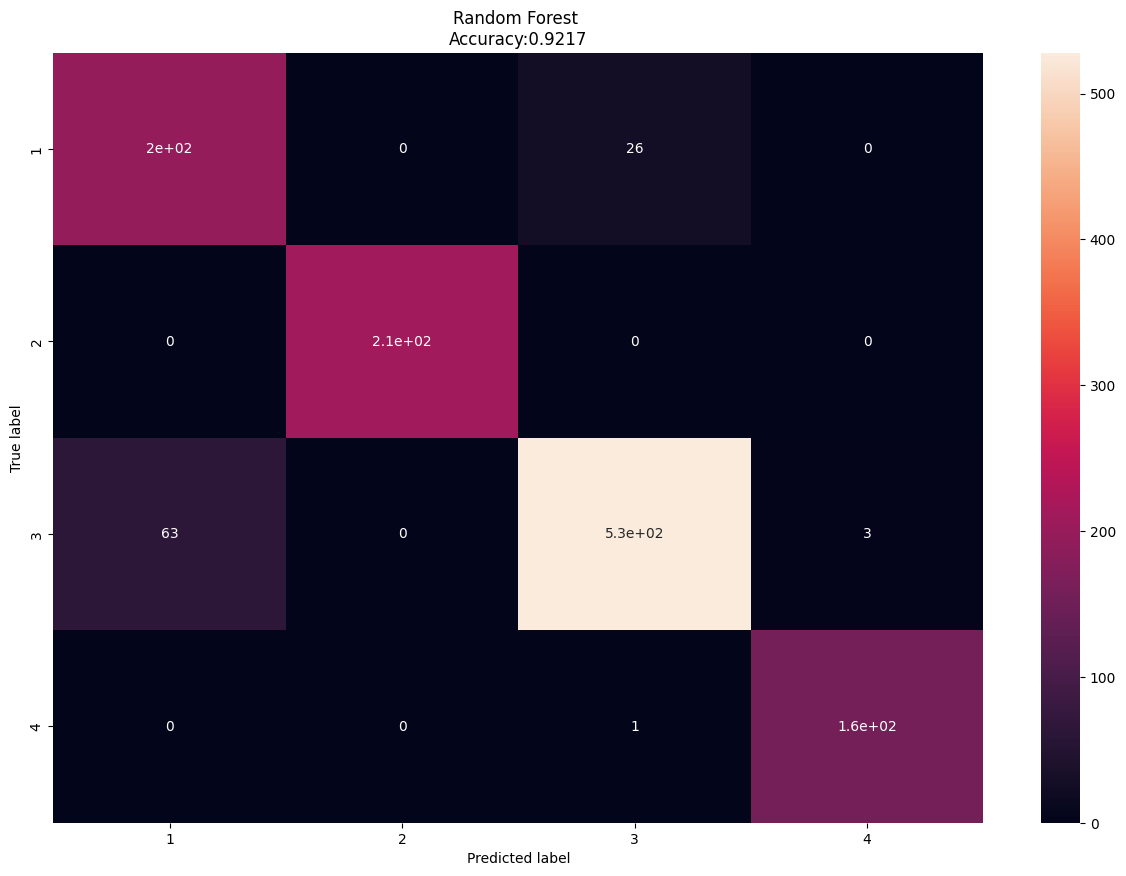

In [9]:
# make color
import seaborn as sns
# from matplotlib import cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# confusion matrices:
# predicted = clf1.predict(test_features)
# clf2 = DT
# clf5 = RF
predicted = clf5.predict(test_features)

confusion_test = confusion_matrix(my_test_lable, predicted)

df_cm = pd.DataFrame(confusion_test,
                    index = [i for i in range(1, 5)], columns = [i for i in range(1, 5)])

print("Confusion matrix: ")
print("    Ăn   Nằm  Đứng  Đi ")
print(df_cm)

plt.figure(figsize=(15,10))

sns.heatmap(df_cm, annot=True)

plt.title('Random Forest \nAccuracy:{0:.4f}'.format(accuracy_score(my_test_lable, 
                                                                       predicted)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

print(classification_report(my_test_lable, predicted))
# Accuracy is calculated follow vertically
# for example:
# accuracy for the 3rd status: 58/(58+23)

#print('Feature importances: {}'.format(clf.feature_importances_))


4


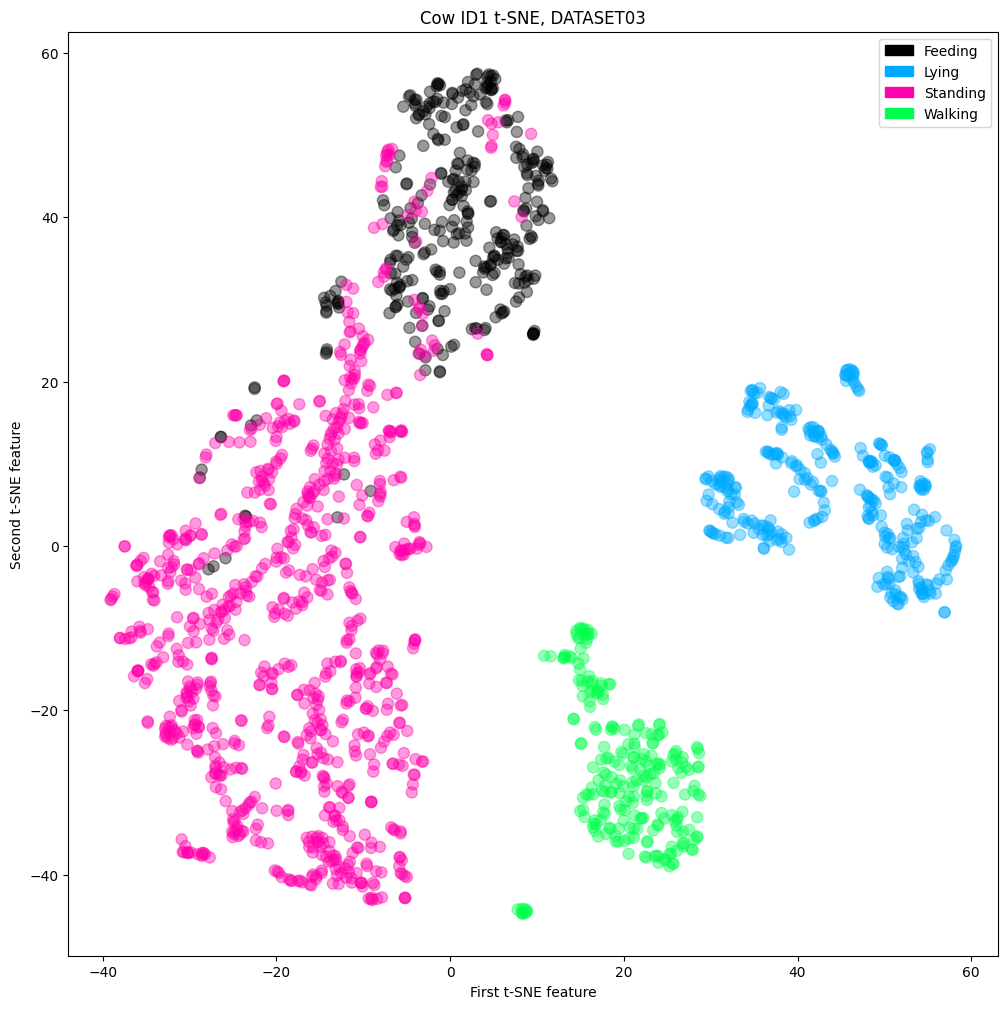

In [10]:
# Visualisation: t-sne

import numpy
# import pandas as pd
# import seaborn as sn
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
# from sklearn import neighbors
import matplotlib.patches as mpatches
from sklearn.tree import export_graphviz


def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    print(num_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#000000', '#00AAFF', '#FF00AA', '#00FF4C', '#ff0000', '#6e8216', '#ff6e00']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels+1, 1), ncolors=num_labels)
    #f = plt.figure(figsize=(10, 10))
    plt.figure(figsize=(12, 12))

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, lw=1)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    
    plt.xlabel('First t-SNE feature')
    plt.ylabel('Second t-SNE feature')
    plt.title('Cow ID1 t-SNE, DATASET03');

    plt.show()


X_visual = np.array(train_features)
y_visual = np.array(my_train_lable, dtype=np.uint8)

n_samples = 300
n_components = 2
perplexity = 30
RS = 1000

from sklearn.manifold import TSNE

X_tsne = TSNE(random_state=RS).fit_transform(X_visual)

plot_labelled_scatter(X_tsne, y_visual,['Feeding', 'Lying', 'Standing', 'Walking'])


In [11]:
# kiem tra 1 sample
i = 250
sample = [test_features[i]]
sample
res = clf1.predict(sample)
print('label kiem tra: ', res)
print('label thuc te: ', my_test_lable[i])

[array([   9.72916667,  907.81527778, -184.975     , -589.56111111,
        -515.4125    , -518.47708333,   13.03730225,  907.82171596,
         185.75507873,  590.93533307,  519.43099925,  523.10413977,
           8.67839651,    3.4189759 ,   17.00584163,   40.27734023,
          64.48657087,   69.42229541,   11.85      ,  906.55      ,
        -191.75      , -578.72222222, -557.9       , -491.4       ])]

label kiem tra:  [1]
label thuc te:  1


In [12]:
# kiem tra  sample
dung = 0
tong = 1187
for i in range(tong):
    sample = [test_features[i]]
    #sample
    #for sam in
    res = clf1.predict(sample)
    #print('label kim tra: ', res)
    #print('label thuc te: ', my_test_lable[i])
    if res == my_test_lable[i]:
        dung = dung + 1
        
print(dung)
print(dung/tong)

1094
0.9216512215669755
